In [29]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


# Overview
- Intro about machine learning and education 
    - Examples, fears, hopes
- Simple Linear Regression
    - 2d Boston
        - Look at scatter plot of RM and MEDV
        - How do we fit a line?
        - How do we know the best fit?
        - How do we optimize?
    - 3d Boston
        - Same stuff
    - More d Boston
        - Same stuff
        - Requires understanding statistics
- Logistic Regression
    - MNIST: Lots of data
    - How does logistic regression work?
    - How do we feed in an image?
- Simple NN with MNIST
- CNN with MNIST
- Conclusion
    

In [4]:
boston_dataset = load_boston()

In [19]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target

In [5]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


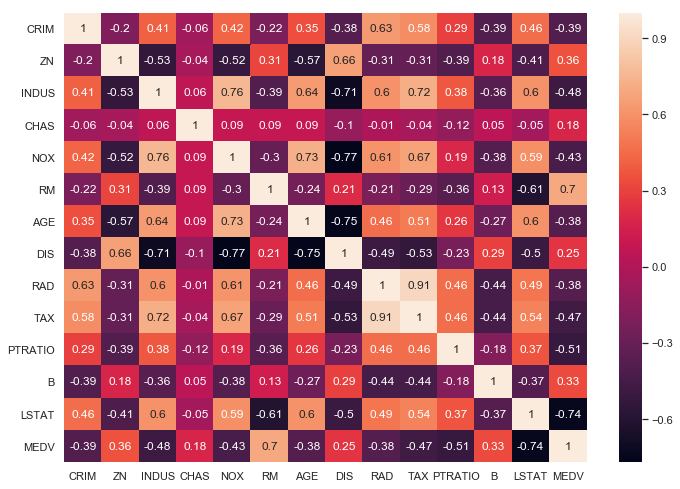

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = boston_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [6]:
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM'], boston_df['CRIM'], boston_df['ZN'], boston_df['INDUS'], boston_df['CHAS'], boston_df['NOX'], boston_df['AGE'], boston_df['DIS'], boston_df['RAD'], boston_df['TAX'], boston_df['PTRATIO'], boston_df['B']], columns = ['LSTAT','RM', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B'])
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM']], columns=['LSTAT', 'RM'])
X = pd.DataFrame(boston_df['RM'], columns=['RM'])
Y = boston_df['MEDV']

In [7]:
only_rooms_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['MEDV']], columns=['RM', 'MEDV'])

# What is Machine Learning?

# What is Machine Learning?
## Consider the familiar example -- RM is average number of rooms, MEDV is median value in $1000s
## We will try to predict the value of a home from the number of rooms.

In [8]:
only_rooms_df.head(10)

,RM,MEDV
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
5,6.430,28.7
6,6.012,22.9
7,6.172,27.1
8,5.631,16.5
9,6.004,18.9


# Does there seem to be any correlation between number of rooms and price?

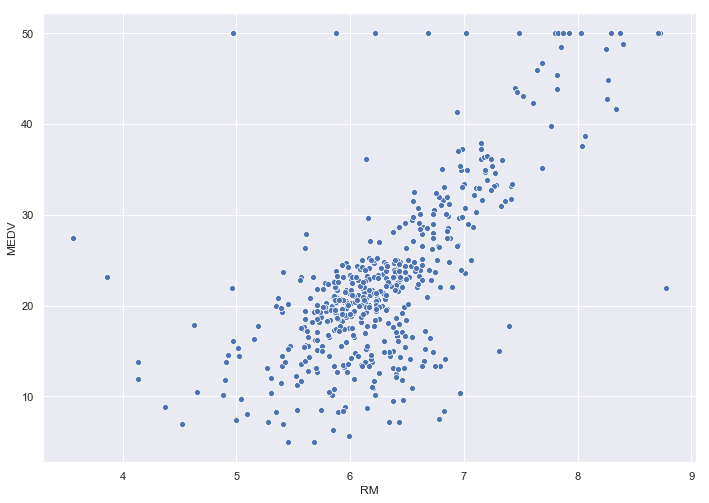

In [13]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

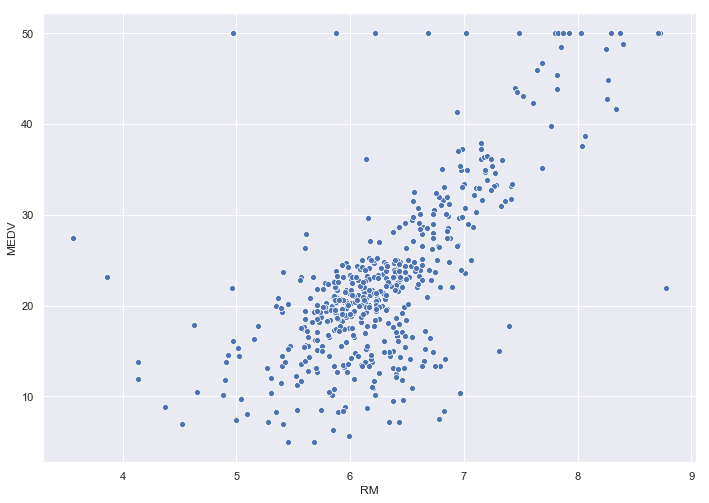

In [10]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## Let's see if we can *fit a line* to this data.

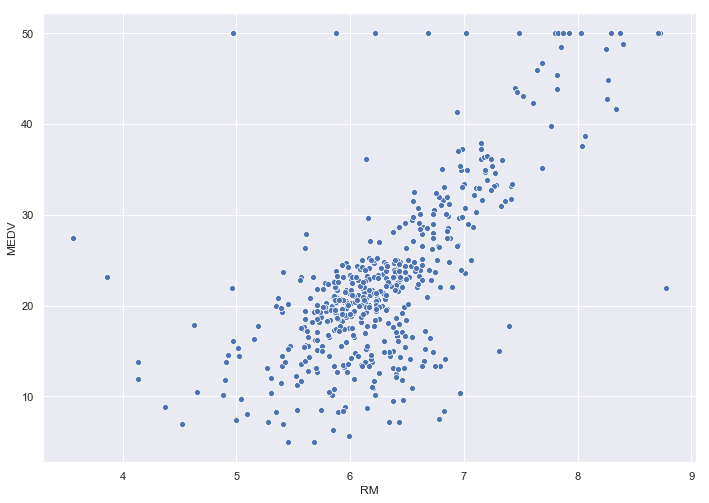

In [11]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## So we want to find $a$ and $b$ such that $y = ax + b$ where $y$ is the price of the house and $b$ is the number of rooms.

# Big Idea
## We have a bunch of data points that sort of make a line.
## We want to find values for $a$ and $b$ in $y = ax + b$ that *fit* the data points.
## We define a criterion for how well a line fits the data.
## We look for a line that optimizes our criterion.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=666)

In [34]:
train['RM'].head()

343    6.696
342    6.540
458    6.301
376    6.649
302    6.495
Name: RM, dtype: float64

In [36]:
lin_model = LinearRegression()
lin_model.fit(train['RM'].to_frame(), train['MEDV'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
lin_model.coef_

array([[9.27368249]])

In [38]:
lin_model.intercept_

array([-35.64009735])

In [22]:
train, test = train_test_split(only_rooms_df, test_size = 0.25, random_state=666)

In [42]:
test['prediction'] = test['RM'] * lin_model.coef_[0] + lin_model.intercept_

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
test['diff_squared'] = (test['prediction'] - test['MEDV']) ** 2

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
test.head()

,RM,MEDV,prediction,diff_squared
81,6.619,23.9,25.742407,3.394464
453,7.393,17.8,32.920237,228.621576
311,6.122,22.1,21.133387,0.934341
291,7.148,37.3,30.648185,44.246642
360,6.398,25.0,23.692923,1.708450


In [48]:
test.diff_squared.sum() / len(test)

42.76818033219253

In [71]:
rooms_lstat_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['MEDV']], columns=['RM', 'LSTAT', 'MEDV'])
train, test = train_test_split(rooms_lstat_df, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(np.c_[train['RM'], train['LSTAT']], train['MEDV'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# test = test.drop(columns='MEDV')
# test['prediction'] =  lin_model.predict(test)
# with_preds = test
# with_preds['MEDV'] = test['MEDV']
with_preds['diff_squared'] = (with_preds['MEDV'] - with_preds['prediction']) ** 2
with_preds.head()

,RM,LSTAT,prediction,MEDV,diff_squared
81,6.619,7.22,27.861800,23.9,15.695861
453,7.393,16.74,26.251842,17.8,71.433626
311,6.122,5.98,25.901409,22.1,14.450713
291,7.148,3.56,33.008254,37.3,18.419088
360,6.398,7.79,26.301045,25.0,1.692718


In [74]:
with_preds.diff_squared.sum() / len(with_preds)

28.06626963161934

In [75]:
mean_squared_error(with_preds.MEDV, with_preds.prediction)

28.06626963161934

In [81]:
rooms_lstat_pt_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['PTRATIO']], columns=['RM', 'LSTAT', 'PTRATIO'])
Y = boston_df['MEDV']
X_train, X_test, Y_train, Y_test = train_test_split(rooms_lstat_pt_df, Y, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
predictions = lin_model.predict(X_test)
mse = mean_squared_error(predictions, Y_test)
r2 = r2_score(predictions, Y_test)
print("mse: {} -- r^2: {}".format(mse, r2))

mse: 26.62571646686159 -- r^2: 0.4956835622307818


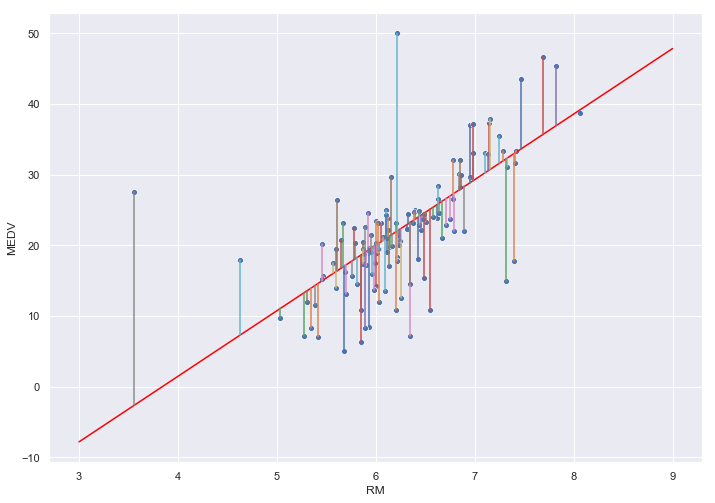

In [39]:
dataset = test
ax = sns.scatterplot(x="RM", y="MEDV", data=dataset)
x = np.linspace(3, 9, 1000)
ax.plot(x, 9.274 * x - 35.64, color='red')

for row in dataset.itertuples():
    ax.plot([row.RM, row.RM], [row.MEDV, 9.274 * row.RM - 35.64])

In [32]:
X_test['MEDV'] = Y_test
test = X_test

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


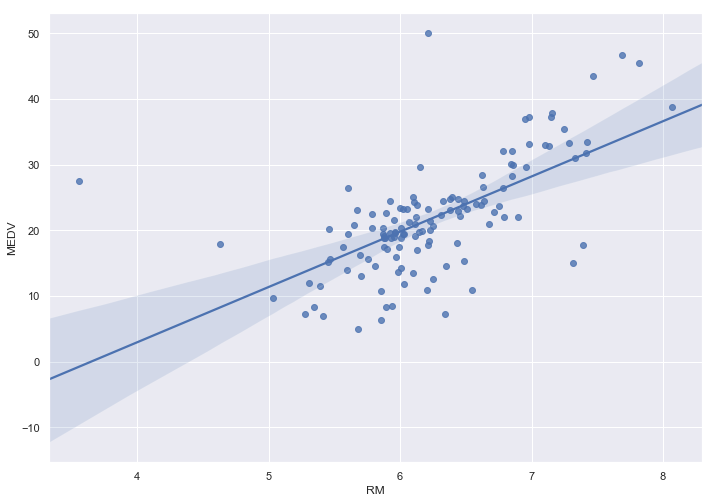

In [34]:
sns.regplot(x="RM", y="MEDV", data=test)

# Another Dataset
## Handwritten digits - can we correctly classify them?
## Much more data this time (70,000 examples)

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

<Figure size 432x288 with 0 Axes>

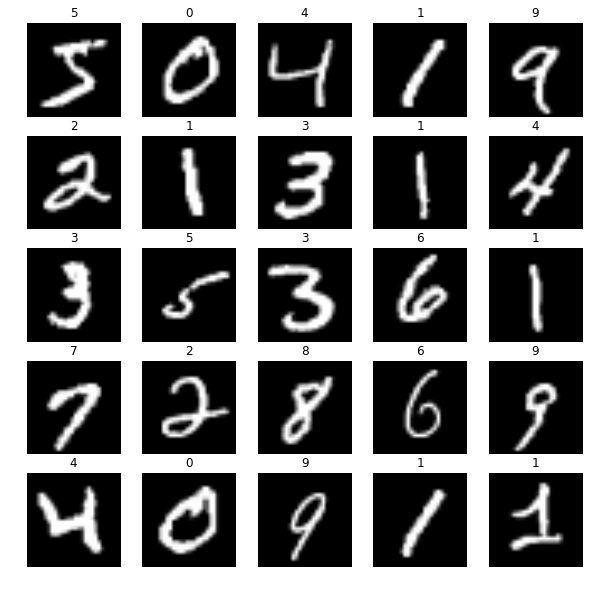

In [18]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for n in range(25):
    img = X_train[n]
    plt.subplot(5,5,n + 1)
    plt.title(Y_train[n])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

## How can we do this? Is our data different than the Boston Housing data?
## What does this data look like?
- Each image is a 28 x 28 matrix of pixel values from 0 to 255

In [38]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

## We can take each 28 x 28 array and make it a 784 dim vector
## Now we have a problem much like the Boston Housing data problem -- we just have a 784 dimensional input.

In [39]:
np.reshape(X_train[0], 784)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

## The output, however, is quite different. In the Boston Housing problem we were predicting a single value, how can we do that here?
## Let's consider a simpler problem: Suppose we have the same dataset, but we are only concerned if the number is a 7 or not a 7.

## We input a 784 dim vector
## We want to output if the image is a 7 or not a 7

## We input a 784 dim vector
## We want to output if the image is a 7 or not a 7 - let's output a 1 if it is a 7 and a 0 if it isn't.

## If this were like our linear regression example we would be looking for coefficients $w_1, w_2, \ldots, w_{784}$ and $c$ such that $$w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c$$ *best fits* our data.

## We'd like our inputs that are 7s to output 1, and everything else to output 0. The linear combination $$w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c$$ could take on any real values, so let's restrict it.

## Consider the sigmoid function 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

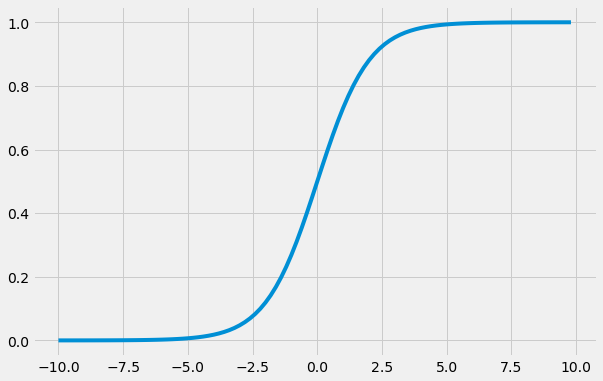

In [67]:
plt.figure(figsize=(9, 6))
plt.style.use('fivethirtyeight')
x = np.arange(-10, 10, 0.2)
plt.axis('on')
plt.plot(x, 1 / (1 + np.exp(-x)))

## This bounds our output between 0 and 1.

## In our linear regression example, we looked at squared error and minimized to find the coefficients that gave us the *best fit*.
## Could we do that here? What would that look like?

## Let $\hat{y}$ represent our output value, the thing we want to be one when we have a 7 or 0 when we don't. Let $y$ be the actual value of our training example.
## Using squared error we could define our loss function as
## $$\mathcal{L}(\hat{y}, y) = (y - \hat{y})^2 $$

## Using squared error we could define our loss function as
## $$\mathcal{L}(\hat{y}, y) = (y - \hat{y})^2 $$
## This turns out to make the optimization problem non-convex.
## Instead, consider
## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## When $y = 1$
## $$ \mathcal{L}(\hat{y}, 1) = - (1) \log(\hat{y}) = - \log(\hat{y}) $$

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## When $y = 1$
## $$ \mathcal{L}(\hat{y}, 1) = - (1) \log(\hat{y}) = - \log(\hat{y}) $$
## Remember, we want to minimize this, so notice that $- \log(\hat{y})$ is minimized when $\hat{y}$ is large, but remember that $\hat{y}$ is bounded between 0 and 1, so the maximum value it can take on is 1. So our loss function wants our estimate to be as close to 1 as possible when our training example is a 7.

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## Similarly, when $y = 0$
## $$ \mathcal{L}(\hat{y}, 0) = - \log(1 - \hat{y}) $$
## So our loss function wants our estimate, $\hat{y}$, to be 0 when our training example is not a 7. 

# Review
## We want to predict if an image is a 7 or not a 7.
## We convert the image from a 28 x 28 array to a 784 vector
## This vector is our input and we want our output to be a 1 if we have a 7 and a 0 if we don't
## The output is computed as follows
$$ z(x) = w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c $$
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
## $\sigma(z)$ is bounded between 0 and 1 and our loss function will help us get the *best values* for $w_1, w_2, \ldots, w_{784}, c $ through optimization.